In [58]:
import numpy as np
import torch
import pandas as pd
from itertools import product
from torch_geometric.data import Data

evt = "/mnt/data0/Trackml_dataset_100_events/Example_3/trackml_100_events/event000021000-"

def semi_fully_connected_graph(event_path):
    hits = pd.read_csv(event_path + 'hits.csv')
    hits = hits[hits['volume_id'].isin([8,13,17])] #only consider barrel detector
    #hits = hits[hits['x'] > 0] #only consider right half of detector
    #hits = hits[hits['y'] > 0] #only consider top half of detector
    #hits = hits[hits['z'] > 0] #only consider front half of detector
    
    hits['layer_id'] = hits['volume_id']*10 + hits['layer_id']
    hits = hits.sort_values(by='layer_id')

    #Create graph object with node feature matrix
    graph = Data()
    
    graph.x = torch.tensor(np.arange(0,hits['hit_id'].to_numpy().shape[0],1))
    graph.hit_id = torch.tensor(hits['hit_id'].to_numpy())

    graph.pos = torch.empty(hits['x'].to_numpy().shape[0],3)
    graph.pos[:,0] = torch.tensor(hits['x'].to_numpy())
    graph.pos[:,1] = torch.tensor(hits['y'].to_numpy())
    graph.pos[:,2] = torch.tensor(hits['z'].to_numpy())
    
    edge_index = np.empty((2,1))

    all_layers = hits['layer_id'].unique()

    for i,layer in enumerate(all_layers):
        #Mask hits df to only include hits from current layer and next layer
        current_layer_hits = hits[hits['layer_id'] == layer].to_numpy()
        next_layer_hits = hits[hits['layer_id'] == all_layers[i+1]].to_numpy()
        
        #Get indices of hits in current and next layer
        current_layer_indices = np.nonzero(np.isin(hits['hit_id'].to_numpy(),current_layer_hits[:,0]))[0]
        next_layer_indices = np.nonzero(np.isin(hits['hit_id'].to_numpy(),next_layer_hits[:,0]))[0]

        #Create edges between hits in current and next layer
        edge_index = np.concatenate((edge_index,np.array(list(product(current_layer_indices,next_layer_indices))).T), axis=1)
    
        #Break if no next next layer exists
        if all_layers[i] == all_layers[-2]:
            break
        
        #Mask for next next layer, get indices and create edges between current and next next layer
        next_next_layer_hits = hits[hits['layer_id'] == all_layers[i+2]]
        next_next_layer_indices = np.nonzero(np.isin(hits['hit_id'].to_numpy(),next_next_layer_hits))[0]
        edge_index = np.concatenate((edge_index,np.array(list(product(next_layer_indices,next_next_layer_indices))).T), axis=1)
    	

    graph.edge_index = torch.tensor(edge_index).to(torch.int64)
    print("Num nodes:",graph.x.shape)
    print("Num edges:",graph.edge_index.shape)
    print("Total number of layers:",hits['layer_id'].unique().shape[0])

    return graph

graph = semi_fully_connected_graph(evt)
torch.save(graph,'hit_graph_barrel_event000021000.pyg')

Num nodes: torch.Size([67865])
Num edges: torch.Size([2, 754610171])
Total number of layers: 10


In [65]:
import random
import torch
import numpy as np

graph = torch.load('hit_graph_tiny_event000021000.pyg')

#Random filter to remove edges and unconnected nodes
def random_filter(graph, p=0.2,seed=42):
    n_edges = graph.edge_index.shape[1]
    print('Number of edges before filter:',n_edges)
    assert p >= 0 and p <= 1, 'p must be between 0 and 1'
    if p > 0.5:
        random.seed(seed)
        keep_edges = random.sample(range(0,graph.edge_index.shape[1]),int(graph.edge_index.shape[1]*(1-p)))
        graph.edge_index = torch.from_numpy(np.take(graph.edge_index.numpy(),keep_edges,axis=1))
        n_filtered = n_edges - int(n_edges*(1-p))
    else:
        random.seed(seed)
        remove_edges = random.sample(range(0,graph.edge_index.shape[1]),int(graph.edge_index.shape[1]*p))
        graph.edge_index = torch.from_numpy(np.delete(graph.edge_index.numpy(),remove_edges,axis=1))
        n_filtered = int(n_edges*p)

    print('Number of edges after filter:',graph.edge_index.shape[1])
    print('Delta:',n_filtered)
    graph = delete_unconnected_nodes(graph)
    return graph

def delete_unconnected_nodes(graph):
    print('Total number of nodes:',graph.num_nodes)
    print('Number of connected nodes:',np.unique(graph.edge_index.numpy()).shape[0])
    graph.x = torch.tensor(np.unique(graph.edge_index.numpy()))
    return graph

graph = random_filter(graph)
torch.save(graph,'hit_graph_tiny_event000021000_filtered.pyg')

print(graph)

Number of edges before filter: 11908211
Number of edges after filter: 9526569
Delta: 2381642
Total number of nodes: 8560
Number of connected nodes: 8560
Data(x=[8560], hit_id=[8560], pos=[8560, 3], edge_index=[2, 9526569])


In [17]:
import torch
import torch_geometric.transforms as T

graph = torch.load('hit_graph_tiny_event000021000.pyg')
print(graph)

linegraph_trafo = T.LineGraph()
print(linegraph_trafo(graph))

Data(x=[8560], hit_id=[8560], pos=[8560, 3], edge_index=[2, 11908211])
Data(hit_id=[8560], pos=[8560, 3], edge_index=[2, 4964001586], num_nodes=6582426)


In [ ]:
import matplotlib.pyplot as plt

plt.hist(graph.x.numpy(),bins=100, histtype='step')
plt.ylabel('Count')
plt.xlabel('Node index')
plt.show()

plt.hist(graph.edge_index.numpy()[0,:],bins=100, label='Source node', histtype='step')
plt.hist(graph.edge_index.numpy()[1,:],bins=100 ,label='Target node', histtype='step')
plt.ylabel('Count')
plt.xlabel('Node index')
plt.legend()
plt.show()

In [45]:
from itertools import combinations
import torch
import torch_geometric.transforms as T
from torch_geometric.data import Data

linegraph_trafo = T.LineGraph()

def build_fc_graph(n_nodes):
    '''
    Builds a fully connected graph with n_nodes, no self-loops and only edges in one direction
    '''
    graph = Data()
    graph.x = torch.tensor(range(n_nodes))
    graph.num_nodes = n_nodes
    
    edge_index_list = list(combinations(range(n_nodes),r=2))
    graph.edge_index = torch.tensor(edge_index_list).T
    return graph

def iterate_linegraph(graph, n, filter=False): #n is the number of tracklet iterations
    print("Original graph:",graph)
    for i in range(n):
        graph = linegraph_trafo(graph)
        print("Linegraph:",graph)
        if graph.edge_index != None: 
            if filter:
                graph = random_filter(graph, p=0.01)
            print("Linegraph iteration",i,":",graph)
            print()
            continue
        
iterate_linegraph(build_fc_graph(10),3,filter=False)

Original graph: Data(x=[10], num_nodes=10, edge_index=[2, 45])
Linegraph: Data(num_nodes=45, edge_index=[2, 120])
Linegraph iteration 0 : Data(num_nodes=45, edge_index=[2, 120])

Linegraph: Data(num_nodes=120, edge_index=[2, 210])
Linegraph iteration 1 : Data(num_nodes=120, edge_index=[2, 210])

Linegraph: Data(num_nodes=210, edge_index=[2, 252])
Linegraph iteration 2 : Data(num_nodes=210, edge_index=[2, 252])



Number of edges before filter: 10
Number of edges after filter: 8
Delta: 2
Total number of nodes: 5
Number of connected nodes: 5
Plots for 5 FC nodes done!
Number of edges before filter: 45
Number of edges after filter: 36
Delta: 9
Total number of nodes: 10
Number of connected nodes: 10
Plots for 10 FC nodes done!
Number of edges before filter: 105
Number of edges after filter: 84
Delta: 21
Total number of nodes: 15
Number of connected nodes: 15
Plots for 15 FC nodes done!
Number of edges before filter: 190
Number of edges after filter: 152
Delta: 38
Total number of nodes: 20
Number of connected nodes: 20
Plots for 20 FC nodes done!
Number of edges before filter: 300
Number of edges after filter: 240
Delta: 60
Total number of nodes: 25
Number of connected nodes: 25
Plots for 25 FC nodes done!


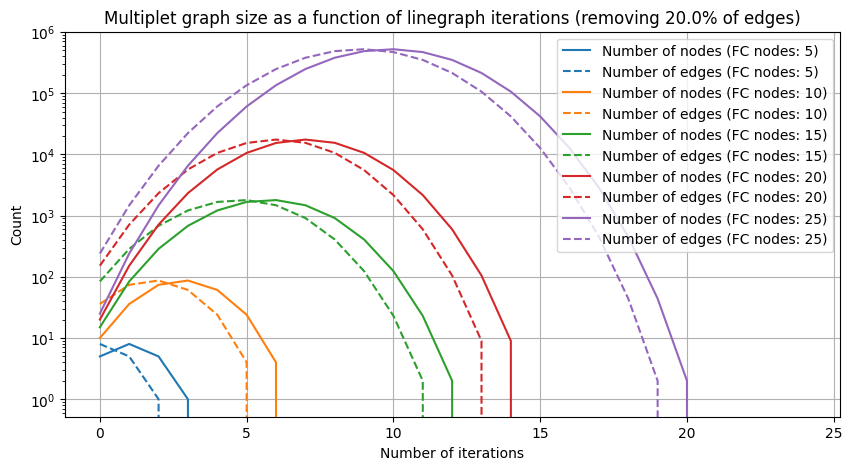

In [19]:
import matplotlib.pyplot as plt 

def plot_multiplet_graph_size(num_fc_nodes, num_iterations):
    '''
    Plots the number of nodes and edges in a multiplet graph as a function of linegraph iterations
    Input: num_fc_nodes - list of number of nodes in the fully connected graph
           num_iterations - number of linegraph iterations
    '''
    prob = 0.2
    if type(num_fc_nodes) != list:
        num_fc_nodes = [num_fc_nodes]

    fig, axs = plt.subplots(1,1, figsize=(10,5))
    axs.set_xlabel('Number of iterations')
    axs.set_ylabel('Count')
    axs.grid()
    axs.set_yscale('log')
    
    axs.set_title(f'Multiplet graph size as a function of linegraph iterations (removing {prob*100}% of edges)')

    for nodes in num_fc_nodes:
        hit_graph = build_fc_graph(nodes)
        hit_graph = random_filter(hit_graph, p=prob)
        num_nodes = [hit_graph.num_nodes]
        num_edges = [hit_graph.edge_index.shape[1]]

        for i in range(num_iterations-1):
            linegraph = linegraph_trafo(hit_graph)

            if linegraph.edge_index == None or linegraph.num_nodes == 0:
                for j in range(num_iterations-i-1):
                    num_nodes.append(0)
                    num_edges.append(0)
                break

            num_nodes.append(linegraph.num_nodes)
            num_edges.append(linegraph.edge_index.shape[1])
            hit_graph = linegraph

        p = axs.plot(range(num_iterations),num_nodes, label=f'Number of nodes (FC nodes: {nodes})')
        c = p[0].get_color()
        axs.plot(range(num_iterations),num_edges, label=f'Number of edges (FC nodes: {nodes})', linestyle='--', color=c)
        print(f'Plots for {nodes} FC nodes done!')

    axs.legend()
    plt.savefig(f'multiplet_graph_size_p{prob}.png')
    plt.show()

plot_multiplet_graph_size([5,10,15,20,25],25)


In [ ]:
from torch_geometric.data import Data

metric_learning_graph = torch.load("/mnt/data1/karres/Example_3/filter/testset/event['000021010'].pyg")

#print(metric_learning_graph)
basic_ml_graph = Data()
basic_ml_graph.edge_index = metric_learning_graph.edge_index
basic_ml_graph.num_nodes = metric_learning_graph.num_nodes

n_nodes = [basic_ml_graph.num_nodes]
n_edges = [basic_ml_graph.edge_index.shape[1]]

for i in range(100):
    if basic_ml_graph.edge_index == None or basic_ml_graph.num_nodes == 0:
        break
    print(f'Iteration {i}')
    print(basic_ml_graph)
    graph = linegraph_trafo(basic_ml_graph)
    basic_ml_graph = graph
    n_nodes.append(graph.num_nodes)
    n_edges.append(graph.edge_index.shape[1])

plt.plot(range(len(n_nodes)),n_nodes, label='Number of nodes')
plt.plot(range(len(n_edges)),n_edges, label='Number of edges')
plt.legend()
plt.show()


"\nfor i in range(100):\n    if basic_ml_graph.edge_index == None or basic_ml_graph.num_nodes == 0:\n        break\n    print(f'Iteration {i}')\n    print(basic_ml_graph)\n    graph = linegraph_trafo(basic_ml_graph)\n    basic_ml_graph = graph\n    n_nodes.append(graph.num_nodes)\n    n_edges.append(graph.edge_index.shape[1])\n\nplt.plot(range(len(n_nodes)),n_nodes, label='Number of nodes')\nplt.plot(range(len(n_edges)),n_edges, label='Number of edges')\nplt.legend()\nplt.show()\n"

In [55]:
print(metric_learning_graph)

print(metric_learning_graph.keys())
print(metric_learning_graph.y)
print(metric_learning_graph.truth_map)

DataBatch(x=[14349], edge_index=[2, 20900], y=[20900], region=[14349], ly=[14349], gphi=[14349], hit_id=[14349], cell_count=[14349], cell_val=[14349], module_index=[14349], phi=[14349], lx=[14349], lz=[14349], geta=[14349], eta=[14349], r=[14349], leta=[14349], weight=[14349], z=[14349], lphi=[14349], track_edges=[2, 13087], radius=[13087], pt=[13087], nhits=[13087], particle_id=[13087], config=[2], event_id=[1], num_nodes=14349, batch=[14349], truth_map=[13087], weights=[20900], ptr=[2], scores=[20900])
['weights', 'batch', 'eta', 'r', 'lx', 'cell_count', 'geta', 'radius', 'z', 'gphi', 'track_edges', 'lphi', 'y', 'module_index', 'scores', 'config', 'ptr', 'ly', 'lz', 'cell_val', 'hit_id', 'num_nodes', 'nhits', 'phi', 'leta', 'weight', 'event_id', 'particle_id', 'truth_map', 'x', 'pt', 'edge_index', 'region']
tensor([ True, False,  True,  ..., False,  True,  True])
tensor([   -1,     8,     2,  ..., 20894,    -1,    -1])


In [ ]:
def apply_mask_to_graph(graph, mask, mask_type='node'):
    '''
    Removes nodes or edges from the graph based based on a mask and reindexes edge_index and track_edges if nodes are removed
    Input: graph - pytorch geometric data object
           mask - boolean mask for nodes or edge features
           mask_type - 'node' or 'edge'
    '''
    mask_len = mask.size(0)
    num_nodes = graph.num_nodes
    num_edges = graph.edge_index.size(1)

    assert (mask_type == 'node' and mask_len == num_nodes) or (mask_type == 'edge' and mask_len == num_edges), 'Mask length does not match number of nodes or edges'

    if mask_type == 'node':
        print('Filtering node features')
        filter_node_feature(graph, mask)
    elif mask_type == 'edge':
        print('Filtering edge features')
        filter_edge_feature(graph, mask)
    else:
        raise ValueError('Invalid mask type')

def filter_node_feature(graph, mask):
    #Create a mapping from old indices to new indices
    mapping = -torch.ones(graph.hit_id.shape[0], dtype=torch.long)  # Initialize mapping
    mapping[mask] = torch.arange(mask.sum())  # Assign new indices

    #Filter edges where both nodes are in the mask
    edge_mask = mask[graph.edge_index[0]] & mask[graph.edge_index[1]]
    filtered_edge_index = graph.edge_index[:, edge_mask]

    #Remap edges to new indices
    new_edge_index = mapping[filtered_edge_index]

    #Filter all node and edge features and create new graph
    node_feature_dict = {
        key: value[mask] for key, value in graph.items()
        if isinstance(value, torch.Tensor) and value.dim() == 1 and 
        value.shape[0] == int(graph.num_nodes)} # Filters only node features
 
    edge_feature_dict = {
        key: value[edge_mask] for key, value in graph.items()
        if isinstance(value, torch.Tensor) and value.dim() == 1 and
        value.shape[0] == graph.edge_index.shape[1]} # Filters only edge features
    
    #Filter track edges if they exist
    if 'track_edges' in graph.keys():
        te_mask = mask[graph.track_edges[0]] & mask[graph.track_edges[1]]
        filtered_track_edges = graph.track_edges[:, te_mask]
        new_track_edges = mapping[filtered_track_edges]

        track_edge_feature_dict = {
            key: value[te_mask] for key, value in graph.items() 
            if isinstance(value, torch.Tensor) and value.dim() == 1 and 
            value.shape[0] == graph.track_edges.shape[1]} # Filters only track edge features
        
    graph.update(node_feature_dict)
    graph.update(edge_feature_dict)
    graph.update(track_edge_feature_dict)
    graph.edge_index = new_edge_index
    graph.track_edges = new_track_edges
    graph.truth_map = build_truth_map(graph.edge_index, graph.track_edges)
    graph.num_nodes = mask.sum() 
    return graph

def build_truth_map(edge_index, track_edges):
    edge_index_exp = edge_index.T.unsqueeze(0)  # Shape (1, n, 2)
    track_edges_exp = track_edges.T.unsqueeze(1)  # Shape (m, 1, 2)

    # Compare all pairs at once
    matches = torch.all(edge_index_exp == track_edges_exp, dim=2)  # Shape (m, n), True where matches exist

    # Get the first matching index for each row in B, or -1 if no match
    truth_map = torch.where(matches.any(dim=1), matches.int().argmax(dim=1), torch.tensor(-1))
    return truth_map


def filter_edge_feature(graph, mask):
    raise NotImplementedError

metric_learning_graph = torch.load("/mnt/data1/karres/Example_3/filter/testset/event['000021010'].pyg")
mask = torch.isin(metric_learning_graph.region, torch.tensor([3,4]))

print(metric_learning_graph)
filtered_graph = filter_node_feature(metric_learning_graph, mask)
print(filtered_graph)

DataBatch(x=[14349], edge_index=[2, 20900], y=[20900], region=[14349], ly=[14349], gphi=[14349], hit_id=[14349], cell_count=[14349], cell_val=[14349], module_index=[14349], phi=[14349], lx=[14349], lz=[14349], geta=[14349], eta=[14349], r=[14349], leta=[14349], weight=[14349], z=[14349], lphi=[14349], track_edges=[2, 13087], radius=[13087], pt=[13087], nhits=[13087], particle_id=[13087], config=[2], event_id=[1], num_nodes=14349, batch=[14349], truth_map=[13087], weights=[20900], ptr=[2], scores=[20900])
Ladies and gentlemen. We got track edges!
DataBatch(x=[7619], edge_index=[2, 9726], y=[9726], region=[7619], ly=[7619], gphi=[7619], hit_id=[7619], cell_count=[7619], cell_val=[7619], module_index=[7619], phi=[7619], lx=[7619], lz=[7619], geta=[7619], eta=[7619], r=[7619], leta=[7619], weight=[7619], z=[7619], lphi=[7619], track_edges=[2, 6517], radius=[6517], pt=[6517], nhits=[6517], particle_id=[6517], config=[2], event_id=[1], num_nodes=7619, batch=[7619], truth_map=[6517], weights=

In [10]:
import glob
import torch
import numpy as np

#Get edgewise efficiency and purity for a metric learning graph
dir_metricl = '/mnt/data1/karres/Example_3/metric_learning/trainset/'
dir_filter = '/mnt/data1/karres/Example_3/filter/trainset/'

def get_eff_pur(dir):
    files = glob.glob(dir + '*.pyg')
    eff, pur = [], []

    for file in files:
        graph = torch.load(file)
        #Eff = number of track_edges in edge_index / number of edges in track_edges
        #Pur = number of track_edges in edge_index / number of edges in edge_index

        edge_index = graph.edge_index.numpy()
        track_edges = graph.track_edges.numpy()

        #Sort both arrays such that the lower index is on top
        edge_index = np.sort(edge_index, axis=0)
        track_edges = np.sort(track_edges, axis=0)

        edge_index_set = set(map(tuple,edge_index.T))
        overlap = sum([tuple(edge) in edge_index_set for edge in track_edges.T])

        eff.append(overlap/track_edges.shape[1])
        pur.append(overlap/edge_index.shape[1])
    
    print(f'Efficiency: {np.mean(eff)}')
    print(f'Purity: {np.mean(pur)}')

print('Metric learning graphs:')
get_eff_pur(dir_metricl)
print('Filtered graphs:')
get_eff_pur(dir_filter)


Metric learning graphs:
Efficiency: 0.9949578596884164
Purity: 0.20752091692884447
Filtered graphs:
Efficiency: 0.8325124792877346
Purity: 0.5409392519286469


## ToDos:
#### -Build element metagraph function IN PROGRESS
#### -Build ambiguity metagraph function
#### -Build graph visualization

In [86]:

graph = Data(edge_index = torch.tensor([[1,2,3,4],[2,3,4,1]]))

def add_metagraph(graph):
    '''
    Add a metagraph to the graph
    Needs to be updated after each linegraph iteration
    '''
    assert hasattr(graph, 'edge_index'), 'Edge index does not exist in graph'
    
    graph.metagraph = [{graph.edge_index[0,i].item(), graph.edge_index[1,i].item()} for i in range(graph.edge_index.shape[1])]
    return graph

def update_metagraph(graph):
    '''
    Updates the metagraph after each linegraph iteration
    '''
    assert hasattr(graph, 'metagraph'), 'Metagraph does not exist in graph'
    assert hasattr(graph, 'edge_index'), 'Edge index does not exist in graph'

    new_metagraph =  []
    for tracklet in graph.edge_index.T:
        trackletA = graph.metagraph[tracklet[0]]
        trackletB = graph.metagraph[tracklet[1]]
        new_tracklet = trackletA|trackletB
        new_metagraph.append(new_tracklet)
    graph.metagraph = new_metagraph
    return graph


In [87]:
graph = build_fc_graph(6)
print('Original graph:',graph)
print(graph.edge_index)
graph = random_filter(graph, p=0.3)
graph = add_metagraph(graph)
print('Filtered graph:',graph)
print(graph.edge_index)
print(graph.metagraph)
graph = linegraph_trafo(graph)
graph = update_metagraph(graph)
print('Doublet graph:',graph)
print(graph.edge_index)
print(graph.metagraph)
graph = linegraph_trafo(graph)
graph = update_metagraph(graph)
print('Triplet graph:',graph)
print(graph.edge_index)
print(graph.metagraph)
graph = linegraph_trafo(graph)
graph = update_metagraph(graph)
print('Quadruplet graph:',graph)
print(graph.edge_index)
print(graph.metagraph)
graph = linegraph_trafo(graph)
graph = update_metagraph(graph)
print('Quintuplet graph:',graph)
print(graph.edge_index)
print(graph.metagraph)


Original graph: Data(x=[6], num_nodes=6, edge_index=[2, 15])
tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4],
        [1, 2, 3, 4, 5, 2, 3, 4, 5, 3, 4, 5, 4, 5, 5]])
Number of edges before filter: 15
Number of edges after filter: 11
Delta: 4
Total number of nodes: 6
Number of connected nodes: 6
Filtered graph: Data(x=[6], num_nodes=6, edge_index=[2, 11], metagraph=[11])
tensor([[0, 0, 0, 1, 1, 1, 1, 2, 3, 3, 4],
        [3, 4, 5, 2, 3, 4, 5, 3, 4, 5, 5]])
[{0, 3}, {0, 4}, {0, 5}, {1, 2}, {1, 3}, {1, 4}, {1, 5}, {2, 3}, {3, 4}, {3, 5}, {4, 5}]
Doublet graph: Data(num_nodes=11, edge_index=[2, 10], metagraph=[10])
tensor([[ 0,  0,  1,  3,  4,  4,  5,  7,  7,  8],
        [ 8,  9, 10,  7,  8,  9, 10,  8,  9, 10]])
[{0, 3, 4}, {0, 3, 5}, {0, 4, 5}, {1, 2, 3}, {1, 3, 4}, {1, 3, 5}, {1, 4, 5}, {2, 3, 4}, {2, 3, 5}, {3, 4, 5}]
Triplet graph: Data(num_nodes=10, edge_index=[2, 5], metagraph=[5])
tensor([[0, 3, 3, 4, 7],
        [9, 7, 8, 9, 9]])
[{0, 3, 4, 5}, {1, 2, 3, 4}, {1, 2, 3, 5}, {